# Project

## Data

In [ ]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

In [ ]:
train = pd.read_csv('train_cache.csv')
train.head()

,iops,lat,block_size,n_jobs,iodepth,read_fraction,load_type,io_type,raid,n_disks,device_type,offset,id
0,712511,386627.74,8,46,6,100,random,read,4+1,24,nvme,0,hse-09142022-013313-z3769
1,709311,388112.33,8,46,6,100,random,read,4+1,24,nvme,0,hse-09142022-013313-z3769
2,712464,386384.72,8,46,6,100,random,read,4+1,24,nvme,0,hse-09142022-013313-z3769
3,711226,387053.72,8,46,6,100,random,read,4+1,24,nvme,0,hse-09142022-013313-z3769
4,710919,387191.78,8,46,6,100,random,read,4+1,24,nvme,0,hse-09142022-013313-z3769


In [ ]:
test = pd.read_csv('test_cache.csv')
test.head()

,iops,lat,block_size,n_jobs,iodepth,read_fraction,load_type,io_type,raid,n_disks,device_type,offset,id
0,21483,613944.00,256,8,4,45,random,read,4+1,24,nvme,0,hse-09132022-180712-z63065
1,21354,610190.00,256,8,4,45,random,read,4+1,24,nvme,0,hse-09132022-180712-z63065
2,20883,613910.75,256,8,4,45,random,read,4+1,24,nvme,0,hse-09132022-180712-z63065
3,21493,610052.62,256,8,4,45,random,read,4+1,24,nvme,0,hse-09132022-180712-z63065
4,21473,606866.62,256,8,4,45,random,read,4+1,24,nvme,0,hse-09132022-180712-z63065


In [ ]:
pd.unique(train[['block_size']]. values.ravel())

array([  8,  16,  32,  64, 256,   4, 128])

In [ ]:
pd.unique(train[['n_jobs']]. values.ravel()).size

32

In [ ]:
pd.unique(train[['iodepth']]. values.ravel()).size

16

In [ ]:
pd.unique(train[['read_fraction']]. values.ravel()).size

101

In [ ]:
pd.unique(train[['io_type']]. values.ravel())

array(['read', 'write'], dtype=object)

In [ ]:
pd.unique(train[['id']]. values.ravel()).size

408

In [ ]:
test['io_type_num'] = test['io_type'] == 'write'

In [ ]:
test.io_type_num = test.io_type_num.replace({ True : 1 , False : 0 })

In [ ]:
y_test = torch.tensor(test[['iops', 'lat']].values)

In [ ]:
X_test = torch.tensor(test[['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)

In [ ]:
train['io_type_num'] = train['io_type'] == 'write'

In [ ]:
train.io_type_num = train.io_type_num.replace({ True : 1 , False : 0 })

In [ ]:
y_tr = torch.tensor(train[['iops', 'lat']].values)

In [ ]:
X_tr = torch.tensor(train[['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)

In [ ]:
pd.unique(test[['id']]. values.ravel())

array(['hse-09132022-180712-z63065', 'hse-09132022-212616-z36709',
       'hse-09132022-203942-z36542', 'hse-09132022-113615-z47578',
       'hse-09132022-113127-z92275', 'hse-09132022-202959-z97080',
       'hse-09132022-130756-z72964', 'hse-09132022-152621-z23474',
       'hse-09132022-222402-z67880', 'hse-09142022-002727-z41754',
       'hse-09132022-215503-z42747', 'hse-09132022-154850-z69269',
       'hse-09132022-162550-z13863', 'hse-09132022-131738-z64548',
       'hse-09132022-163352-z28622', 'hse-09132022-203624-z40860',
       'hse-09132022-111214-z18642', 'hse-09132022-230720-z49925',
       'hse-09132022-180046-z99430', 'hse-09132022-162239-z71118',
       'hse-09132022-115719-z1844', 'hse-09132022-130309-z70101',
       'hse-09132022-143919-z2607', 'hse-09132022-191917-z69202',
       'hse-09132022-105038-z85297', 'hse-09132022-125820-z33361',
       'hse-09132022-200733-z61475', 'hse-09132022-174129-z68191',
       'hse-09132022-131108-z11709', 'hse-09132022-221738-z10431

## Graphs

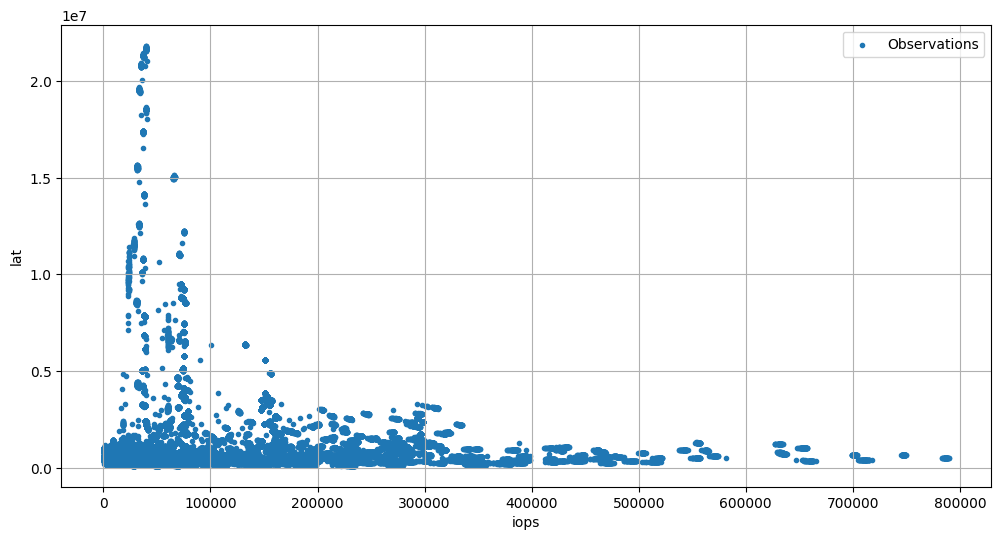

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(y_tr[:, 0], y_tr[:, 1], marker='.', label='Observations', linewidth=1)

plt.xlabel("iops")
plt.ylabel("lat")
plt.grid()
plt.legend()
plt.show()

## Scalers

In [ ]:
from sklearn.base import TransformerMixin, BaseEstimator
import numpy as np
from dataclasses import dataclass

# from https://github.com/HEPML-AnomalyDetection/CATHODE/blob/4e96989296193da18508710afbfa3b37fffe5952/data_handler.py
def logit_transform_inverse(data, datamin, datamax):
    dataout = (datamin + datamax*np.exp(data))/(1 + np.exp(data))
    return dataout

def quick_logit(x, x_min, x_max, eps):
    x_norm = (x-x_min)/(x_max-x_min)
    x_norm = x_norm[((x_norm != 0) & (x_norm != 1)).all(axis=1)]
    x_norm[x_norm == 0] += eps
    x_norm[x_norm == 1] -= eps
    logit = np.log(x_norm/(1-x_norm))
    logit = logit[~np.isnan(logit).any(axis=1)]
    return logit

class LogitScaler(TransformerMixin, BaseEstimator):

    def __init__(self, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.x_max = None
        self.x_min = None

    def fit(self, X, y=None):
        self.x_min = np.min(X, axis=0) - self.eps
        self.x_max = np.max(X, axis=0) + self.eps
        return self

    def transform(self, X):
        return quick_logit(X, self.x_min, self.x_max, self.eps)

    def inverse_transform(self, X):
        return logit_transform_inverse(X, self.x_min, self.x_max)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

scaler = make_pipeline(LogitScaler(eps=0.1), StandardScaler())

In [ ]:
y_tr_ss = scaler.fit_transform(train[['iops', 'lat']].values)
y_test_ss = scaler.transform(test[['iops', 'lat']].values)

<ipython-input-20-a80eb4482932>:15: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm))


In [ ]:
stscaler = StandardScaler()

In [ ]:
X_tr_ss = stscaler.fit_transform(train[['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)
X_test_ss = stscaler.transform(test[['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)

another

https://github.com/gpapamak/maf/blob/master/ml/models/mafs.py

https://github.com/e-hulten/maf

## MY maf

In [ ]:
import numpy as np
import torch
import torch.nn as nn

class MaskedLinear(nn.Linear):
    def __init__(self, in_features, out_features, mask):
        super(MaskedLinear, self).__init__(in_features, out_features)
        self.register_buffer('mask', mask)

    def forward(self, x):
        return F.linear(x.to(torch.float32), self.mask.to(torch.float32) * self.weight.to(torch.float32), self.bias)

class MADE(nn.Module):
    def __init__(self, input_size, hidden_sizes):
        super(MADE, self).__init__()
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes

        self.layers = nn.ModuleList()
        last_size = input_size
        for hidden_size in hidden_sizes:
            mask = torch.randint(0, 2, (last_size, hidden_size))
            self.layers.append(MaskedLinear(last_size, hidden_size, mask))
            last_size = hidden_size
        mask = torch.randint(0, 2, (last_size, input_size))
        self.layers.append(MaskedLinear(last_size, input_size, mask))

    def forward(self, x):
        for layer in self.layers:
            x = F.relu(layer(x))
        return x

In [ ]:
class MAF(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_flows):
        super(MAF, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_flows = num_flows

        self.in_layers = nn.ModuleList()
        for i in range(num_flows):
            self.in_layers.append(MADE(input_size, hidden_size))

    def forward(self, inputs):
        x = inputs
        for layer in self.in_layers:
            x = F.relu(layer(x))
        return x

def train_maf_model(train_loader, model, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch_idx, data in enumerate(train_loader):
            optimizer.zero_grad()
            data = data.view(data.size(0), -1)
            output = model(data)
            loss = F.mse_loss(output.to(torch.float32), data.to(torch.float32))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print('Epoch {} - Average Loss: {:.4f}'.format(epoch+1, total_loss/len(train_loader)))

In [ ]:
batch_size = 32
num_flows = 10
hidden_dim = [6]
lr = 1e-2
num_epochs = 50


train = X_tr

train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size,)

model = MAF(train.shape[1], hidden_dim, output_size=2, num_flows=num_flows)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_maf_model(train_loader, model, optimizer, num_epochs)

Epoch 1 - Average Loss: 2384.0951
Epoch 2 - Average Loss: 2294.5832
Epoch 3 - Average Loss: 2294.5710
Epoch 4 - Average Loss: 2294.5660
Epoch 5 - Average Loss: 2294.5630
Epoch 6 - Average Loss: 2294.5606
Epoch 7 - Average Loss: 2294.5584
Epoch 8 - Average Loss: 2294.5561
Epoch 9 - Average Loss: 2294.5539
Epoch 10 - Average Loss: 2294.5517
Epoch 11 - Average Loss: 2294.5495
Epoch 12 - Average Loss: 2294.5474
Epoch 13 - Average Loss: 2294.5452
Epoch 14 - Average Loss: 2294.5432
Epoch 15 - Average Loss: 2294.5411
Epoch 16 - Average Loss: 2294.5391
Epoch 17 - Average Loss: 2294.5371
Epoch 18 - Average Loss: 2294.5351
Epoch 19 - Average Loss: 2294.5332
Epoch 20 - Average Loss: 2294.5312
Epoch 21 - Average Loss: 2294.5293
Epoch 22 - Average Loss: 2294.5275
Epoch 23 - Average Loss: 2294.5256
Epoch 24 - Average Loss: 2294.5238
Epoch 25 - Average Loss: 2294.5220
Epoch 26 - Average Loss: 2294.5202
Epoch 27 - Average Loss: 2294.5184
Epoch 28 - Average Loss: 2294.5167
Epoch 29 - Average Loss: 2294